In [27]:
import math, sys 
import numpy as np
import sympy as sp
from scipy import sparse
%matplotlib inline
from sympy import fourier_series, pi
from scipy.fftpack import *
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
from scipy.special import hermite
from math import factorial
count = 0

In [28]:
def surfaceplot(U, tspan, xspan, M): 
    N = M**2
    X, T = np.meshgrid(tspan, xspan)
    
    fig = plt.figure(figsize=plt.figaspect(0.3))

    ax1 = fig.add_subplot(1, 4, 2,projection='3d')
    surf = ax1.plot_surface(X, T, U, linewidth=0, cmap=cm.jet, antialiased=True)
    ax1.set_title('Approximation')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Space')
    ax1.set_zlabel('$\psi$')
    
    plt.tight_layout()
    ax1.view_init(30,230)
    
    fig.savefig(path.join("plot.png".format(count)),dpi=600)
    plt.draw()

In [29]:
# Definição do fator que multiplica o polinômio de Hermite, consideraremos que a massa da partícula é 1, 
# bem com a constante verdadeira de planck, o omega pertencente a equação vale pi para que a multiplicação
# inicial seja por 1, isso é possível porque o tamanho desses fatores são pequenos o suficiente para não 
# serem necessários para a análise.

def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px


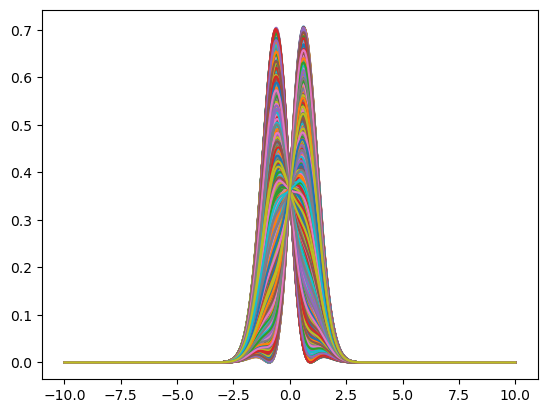

In [46]:
'''
Método de Crank-Nicolson para a solução da equação de Schrödinger em uma única dimensão
    ih * u_t = h_2/2m * u_xx + Vu

Com as condições de contorno não incluídas nessa etapa para que o controle preditivo faça as alterações
Com a equação inicial sendo decidida pelos polinômios de hermite de primeiro e segundo grau

u(x,0) = 0.80 * psi(0, x) + 0.60 * psi(1,x)

A interpretação foi ajustada a partir do código em python da Msc. Mirian Silva
'''

def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    #Discretização espacial
    dx = (xL - x0)/(3*M-1) #0.02

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(N/3-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) #0.0004
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return (psi_c, ts, xs)

U, ts, xs = CrankNicolson(M = 1000, O = -10, L = 10, T = 10)
#surfaceplot(U, ts, xs, M = 1000)

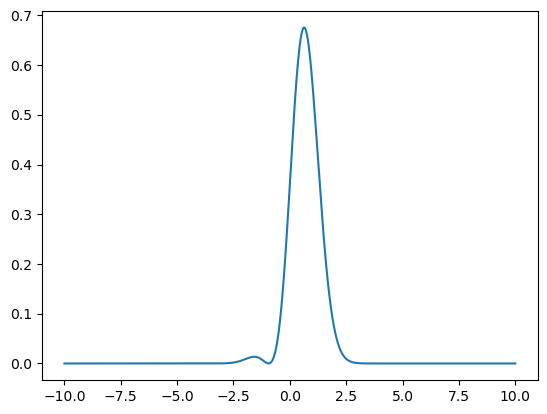

In [44]:
plt.plot(xs, np.absolute(U[0:1000, 0])**2)